<center><b>Installing Libraries</b></center>

In [ ]:
pip install numpy

^C
Note: you may need to restart the kernel to use updated packages.


     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     --------------------------------------- 0.0/12.9 MB 653.6 kB/s eta 0:00:20
     ---------------------------------------- 0.1/12.9 MB 1.0 MB/s eta 0:00:13
      --------------------------------------- 0.3/12.9 MB 2.2 MB/s eta 0:00:06
     -- ------------------------------------- 0.8/12.9 MB 4.3 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.9 MB 8.5 MB/s eta 0:00:02
     --------- ------------------------------ 3.0/12.9 MB 11.9 MB/s eta 0:00:01
     ----------- ---------------------------- 3.6/12.9 MB 12.0 MB/s eta 0:00:01
     ------------ --------------------------- 4.0/12.9 MB 12.3 MB/s eta 0:00:01
     -------------- ------------------------- 4.5/12.9 MB 12.1 MB/s eta 0:00:01
     -------------- ------------------------- 4.5/12.9 MB 12.1 MB/s eta 0:00:01
     -------------- ------------------------- 4.5/12.9 MB 12.1 MB/s eta 0:00:01
     -------------- ------------------------- 4.5/12


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------- ----------------------- 3.4/8.1 MB 20.2 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 16.8 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 11.5 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 9.1 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 25.8 MB/s  0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6

In [10]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install ipywidgets

   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   ---------------------------------------- 914.9/914.9 kB 13.9 MB/s  0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 17.6 MB/s  0:00:00

   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   ---------------------------------------- 3/3 [ipywidgets]

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


<h1><center>GPU + env config</center></h1>

In [2]:
# Cell A: GPU detection & basic config
import os, random, time
from pathlib import Path
import numpy as np
import torch

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Dataset folder (change if needed)
DATA_ROOT = Path("C:/Users/tarun/Desktop/final project/Dataset_plant")
assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT.resolve()}"

# Device detection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("CUDA device count:", torch.cuda.device_count())
    print("CUDA name:", torch.cuda.get_device_name(0))
    # cudnn tuning
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
else:
    print("CUDA not available — running on CPU")

# Other config
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4 if os.name != 'nt' else 0  # set 0 on Windows to avoid spawn issues
SAVE_DIR = Path("saved_models"); SAVE_DIR.mkdir(exist_ok=True)


Using device: cpu
CUDA not available — running on CPU


class-wise 70:30 split + transforms + GPU-ready loaders

In [3]:
# Cell B (Updated): class-wise 70:30 split + transforms + GPU-ready loaders
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

# --------- 1. Transforms ----------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# --------- 2. Collect all (file, label) pairs ----------
exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
rows = []
for class_dir in sorted(DATA_ROOT.iterdir()):
    if class_dir.is_dir():
        label = class_dir.name
        image_files = [p for p in class_dir.glob("*") if p.suffix.lower() in exts]
        for img_path in image_files:
            rows.append({"filepath": str(img_path), "label": label})
df = pd.DataFrame(rows)
print(f"Total images found: {len(df)} in {df['label'].nunique()} classes")

# --------- 3. Class-wise 70:30 split ----------
train_df_list, val_df_list = [], []
for cls, group in df.groupby("label"):
    train_part, val_part = train_test_split(
        group,
        test_size=0.30,
        random_state=SEED,
        shuffle=True
    )
    train_df_list.append(train_part)
    val_df_list.append(val_part)
train_df = pd.concat(train_df_list).reset_index(drop=True)
val_df   = pd.concat(val_df_list).reset_index(drop=True)

print(f"Train set: {len(train_df)} images,  Val set: {len(val_df)} images")

# --------- 4. Define custom dataset ----------
class PlantDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.classes = sorted(df['label'].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['filepath']).convert("RGB")
        img = self.transform(img)
        label = self.class_to_idx[row['label']]
        return img, label

train_dataset = PlantDataset(train_df, train_transform)
val_dataset   = PlantDataset(val_df, val_transform)

class_names = train_dataset.classes
print("Classes:", len(class_names))

# --------- 5. DataLoaders (GPU optimized) ----------
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))

print("✅ DataLoaders ready.")
print("Train batches:", len(train_loader), " Val batches:", len(val_loader))


Total images found: 61486 in 39 classes
Train set: 43030 images,  Val set: 18456 images
Classes: 39
✅ DataLoaders ready.
Train batches: 1345  Val batches: 577


In [4]:
# Cell C: build ResNet18, optimizer, criterion, scheduler
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from pathlib import Path

# Save dir (ensure exists)
try:
    SAVE_DIR  # if defined earlier
except NameError:
    SAVE_DIR = Path("saved_models")
SAVE_DIR = Path(SAVE_DIR)
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Build model (ResNet18) and replace final layer
num_classes = len(class_names)
model = models.resnet18(pretrained=True)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)

# Move model to device
model = model.to(device)

# Freeze backbone for initial epochs (train final layer only)
freeze_backbone = True
if freeze_backbone:
    for name, param in model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False

# Loss, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Model ready. Num classes:", num_classes)
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Model ready. Num classes: 39
Trainable parameters: 20007


c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Cell D: training loop (uses device, train_loader, val_loader)
import time
from tqdm.auto import tqdm
import torch
from sklearn.metrics import accuracy_score

EPOCHS = 12
best_val_acc = 0.0
best_ckpt_path = SAVE_DIR / "best_resnet18.pth"

use_amp = torch.cuda.is_available()  # mixed precision if GPU exists
scaler = torch.cuda.amp.GradScaler() if use_amp else None

def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    losses = []
    all_preds, all_labels = [], []
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())
        losses.append(loss.item())
    avg_loss = float(np.mean(losses))
    acc = float(accuracy_score(all_labels, all_preds))
    return avg_loss, acc

def validate(model, loader, criterion, device):
    model.eval()
    losses = []
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy())
            losses.append(loss.item())
    avg_loss = float(np.mean(losses))
    acc = float(accuracy_score(all_labels, all_preds))
    return avg_loss, acc

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler=scaler)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    elapsed = time.time() - t0
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} | {elapsed:.1f}s")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        ckpt = {
            "model_state_dict": model.state_dict(),
            "class2idx": {c:i for i,c in enumerate(class_names)},
            "img_size": IMG_SIZE,
            "epoch": epoch
        }
        torch.save(ckpt, best_ckpt_path)
        print("Saved best checkpoint to", best_ckpt_path)

    # Unfreeze backbone after a few epochs for fine-tuning
    if freeze_backbone and epoch == 3:
        print("Unfreezing entire model for fine-tuning.")
        for param in model.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
        scaler = torch.cuda.amp.GradScaler() if use_amp else None


Epoch 1/12 | train_loss=2.1871 train_acc=0.5065 | val_loss=1.2677 val_acc=0.7762 | 1425.1s
Saved best checkpoint to saved_models\best_resnet18.pth


Epoch 2/12 | train_loss=1.0662 train_acc=0.8137 | val_loss=0.7535 val_acc=0.8589 | 1355.9s
Saved best checkpoint to saved_models\best_resnet18.pth


Epoch 3/12 | train_loss=0.7295 train_acc=0.8601 | val_loss=0.5507 val_acc=0.8866 | 1348.7s
Saved best checkpoint to saved_models\best_resnet18.pth
Unfreezing entire model for fine-tuning.


Epoch 4/12 | train_loss=0.2415 train_acc=0.9442 | val_loss=0.1028 val_acc=0.9732 | 2724.9s
Saved best checkpoint to saved_models\best_resnet18.pth


Epoch 5/12 | train_loss=0.0997 train_acc=0.9749 | val_loss=0.0629 val_acc=0.9841 | 2689.5s
Saved best checkpoint to saved_models\best_resnet18.pth


Epoch 6/12 | train_loss=0.0604 train_acc=0.9853 | val_loss=0.0403 val_acc=0.9893 | 2693.6s
Saved best checkpoint to saved_models\best_resnet18.pth


Epoch 7/12 | train_loss=0.0446 train_acc=0.9890 | val_loss=0.0353 val_acc=0.9899 | 2692.4s
Saved best checkpoint to saved_models\best_resnet18.pth


Epoch 8/12 | train_loss=0.0339 train_acc=0.9922 | val_loss=0.0281 val_acc=0.9918 | 2695.7s
Saved best checkpoint to saved_models\best_resnet18.pth


Epoch 9/12 | train_loss=0.0279 train_acc=0.9933 | val_loss=0.0244 val_acc=0.9931 | 2693.8s
Saved best checkpoint to saved_models\best_resnet18.pth


Epoch 10/12 | train_loss=0.0219 train_acc=0.9947 | val_loss=0.0204 val_acc=0.9944 | 2699.2s
Saved best checkpoint to saved_models\best_resnet18.pth


Epoch 11/12 | train_loss=0.0184 train_acc=0.9956 | val_loss=0.0196 val_acc=0.9944 | 2685.4s


Epoch 12/12 | train_loss=0.0167 train_acc=0.9958 | val_loss=0.0171 val_acc=0.9952 | 2677.8s
Saved best checkpoint to saved_models\best_resnet18.pth


Checkpoint keys: ['model_state_dict', 'class2idx', 'img_size', 'epoch']
Loaded class2idx from checkpoint.
Num classes: 39


c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Evaluating:   0%|          | 0/577 [00:00<?, ?it/s]

Validation accuracy: 0.9952 (18456 samples)
Classification report saved to saved_models\classification_report_val.csv

Top-level report:
                                            precision    recall  f1-score  \
Apple___Apple_scab                           0.993377  1.000000  0.996678   
Apple___Black_rot                            1.000000  1.000000  1.000000   
Apple___Cedar_apple_rust                     1.000000  1.000000  1.000000   
Apple___healthy                              1.000000  1.000000  1.000000   
Background_without_leaves                    0.991304  0.997085  0.994186   
Blueberry___healthy                          1.000000  1.000000  1.000000   
Cherry___Powdery_mildew                      1.000000  1.000000  1.000000   
Cherry___healthy                             1.000000  0.996667  0.998331   
Corn___Cercospora_leaf_spot Gray_leaf_spot   0.893293  0.976667  0.933121   
Corn___Common_rust                           1.000000  0.974860  0.987270   

               

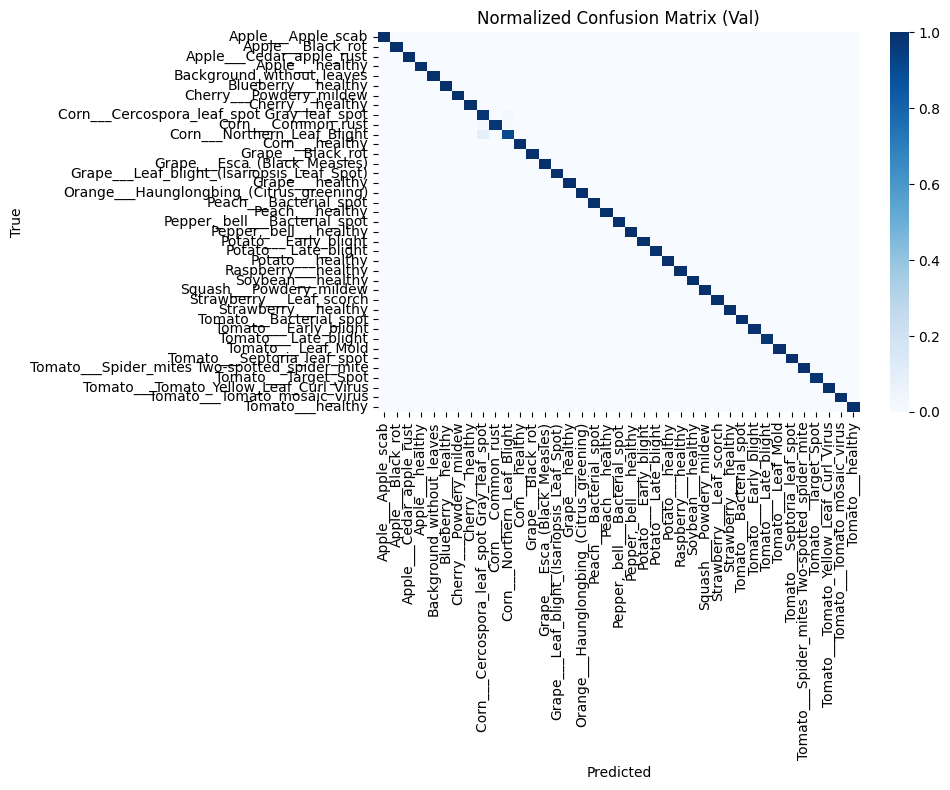

Confusion matrix image saved to saved_models\confusion_matrix_val.png
Raw confusion matrix saved to saved_models\confusion_matrix_val.npy
Saved human-readable classification_report_val.txt


In [5]:
# Cell E (REPLACEMENT): Evaluate saved best model, print classification report, plot + save confusion matrix
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd

# Config / paths
try:
    best_ckpt_path
except NameError:
    best_ckpt_path = Path("saved_models") / "best_resnet18.pth"
SAVE_DIR = Path("saved_models")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

if not best_ckpt_path.exists():
    raise FileNotFoundError(f"No saved checkpoint found at {best_ckpt_path}. Train and save first.")

# Load checkpoint (map to device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(best_ckpt_path, map_location=device)
print("Checkpoint keys:", list(ckpt.keys()))

# Recover class mapping
if "class2idx" in ckpt:
    class2idx = ckpt["class2idx"]
    print("Loaded class2idx from checkpoint.")
else:
    # fallback: try to use class_names from earlier dataset
    try:
        class2idx = {c:i for i,c in enumerate(class_names)}
        print("Using class_names from dataset for mapping.")
    except Exception:
        raise RuntimeError("No class2idx in checkpoint and class_names not available. Save class2idx when saving checkpoint.")

idx2class = {v:k for k,v in class2idx.items()}
num_classes = len(class2idx)
print("Num classes:", num_classes)

# Build model architecture (must match training architecture)
model_eval = models.resnet18(pretrained=False)
in_feats = model_eval.fc.in_features
model_eval.fc = nn.Linear(in_feats, num_classes)

# Handle possible 'module.' prefix in state_dict keys (DataParallel)
state_dict = ckpt.get("model_state_dict", ckpt)
if any(k.startswith("module.") for k in state_dict.keys()):
    new_state = {}
    for k,v in state_dict.items():
        new_state[k.replace("module.","")] = v
    state_dict = new_state

# Try loading state dict (catch size/key mismatches)
try:
    model_eval.load_state_dict(state_dict)
except Exception as e:
    # best effort: try to copy matching parameters
    print("Warning: strict load_state_dict failed:", e)
    # attempt non-strict load
    model_eval.load_state_dict(state_dict, strict=False)
    print("Loaded state dict with strict=False (some keys may have been ignored).")

model_eval = model_eval.to(device)
model_eval.eval()

# Choose evaluation loader (val_loader expected from Cell B)
if 'val_loader' not in globals():
    raise RuntimeError("val_loader not found. Ensure Cell B ran and created val_loader.")
if len(val_loader) == 0:
    raise RuntimeError("val_loader appears empty. Check your splits.")

# Run evaluation on val_loader
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Evaluating", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        outputs = model_eval(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
acc = (y_true == y_pred).mean()
print(f"Validation accuracy: {acc:.4f} ({y_true.size} samples)")

# Classification report (as text and saved CSV)
target_names = [idx2class[i] for i in range(num_classes)]
report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()
report_csv_path = SAVE_DIR / "classification_report_val.csv"
report_df.to_csv(report_csv_path, index=True)
print("Classification report saved to", report_csv_path)
print("\nTop-level report:")
print(report_df.head(10))

# Confusion matrix (normalized per true class) and plot
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-9)

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, vmax=1.0, vmin=0.0, cmap="Blues", xticklabels=target_names, yticklabels=target_names, cbar=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Val)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
cm_fig_path = SAVE_DIR / "confusion_matrix_val.png"
plt.savefig(cm_fig_path, dpi=200)
plt.show()
print("Confusion matrix image saved to", cm_fig_path)

# Save raw confusion matrix numeric array
np.save(SAVE_DIR / "confusion_matrix_val.npy", cm)
print("Raw confusion matrix saved to", (SAVE_DIR / "confusion_matrix_val.npy"))

# Also save report as readable text (optional)
with open(SAVE_DIR / "classification_report_val.txt", "w") as f:
    f.write(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
print("Saved human-readable classification_report_val.txt")

# If you want to run on a separate test set in future, create 'test_loader' and run similar block.


In [13]:
# Run this cell BEFORE running the inference/upload widget.
# It loads the checkpoint and creates model_inf, preprocess, idx2class, device.

import torch
import torch.nn as nn
from torchvision import models, transforms
from pathlib import Path

# Path to checkpoint (update if you saved under a different name)
CKPT = Path("saved_models/best_resnet18.pth")
if not CKPT.exists():
    raise FileNotFoundError(f"Checkpoint not found at {CKPT}. Run training first or point to the correct file.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# load checkpoint
ckpt = torch.load(CKPT, map_location="cpu")
print("Checkpoint keys:", list(ckpt.keys()))

# get class2idx (or fallback to dataset object if available)
if "class2idx" in ckpt:
    class2idx = ckpt["class2idx"]
else:
    # try to recover from dataset if present
    if "class_names" in globals():
        class2idx = {c:i for i,c in enumerate(class_names)}
    else:
        raise RuntimeError("No class2idx in checkpoint and class_names not present. Save class2idx with the checkpoint.")

idx2class = {v:k for k,v in class2idx.items()}
num_classes = len(class2idx)
print("Num classes:", num_classes)

# Build ResNet18 (modern API - avoid pretrained=True warning)
model_inf = models.resnet18(weights=None)
in_feats = model_inf.fc.in_features
model_inf.fc = nn.Linear(in_feats, num_classes)

# load state_dict (handle possible 'module.' prefix)
state = ckpt.get("model_state_dict", ckpt)
if any(k.startswith("module.") for k in state.keys()):
    new_state = {}
    for k,v in state.items():
        new_state[k.replace("module.","")] = v
    state = new_state

# Try strict load, fallback to strict=False
try:
    model_inf.load_state_dict(state)
except Exception as e:
    print("Warning: strict load failed:", e)
    model_inf.load_state_dict(state, strict=False)
    print("Loaded state with strict=False (some keys may be missing/extra).")

model_inf = model_inf.to(device)
model_inf.eval()

# Build preprocess transform (must match validation transforms used during training)
IMG_SIZE = ckpt.get("img_size", 224)
preprocess = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Export names expected by inference cell
globals().update({
    "model_inf": model_inf,
    "preprocess": preprocess,
    "device": device,
    "idx2class": idx2class
})

print("Model loaded to device and preprocess created. Ready for inference.")


Using device: cpu
Checkpoint keys: ['model_state_dict', 'class2idx', 'img_size', 'epoch']
Num classes: 39
Model loaded to device and preprocess created. Ready for inference.


In [14]:
# Inference widget: batch uploads, show only disease name on image + save to CSV
import io, matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import torch
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# ---- Requirements ----
required = ["model_inf", "preprocess", "device", "idx2class", "SAVE_DIR"]
missing = [r for r in required if r not in globals()]
if missing:
    raise RuntimeError(f"Missing required objects: {missing}. Run previous cells first.")
SAVE_DIR = Path(SAVE_DIR)
SAVE_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV = SAVE_DIR / "predictions.csv"

# Create or load predictions CSV
if PRED_CSV.exists():
    pred_df = pd.read_csv(PRED_CSV)
else:
    pred_df = pd.DataFrame(columns=["filename", "pred_label", "timestamp"])

# ---- UI ----
uploader = widgets.FileUpload(accept='image/*', multiple=True)
out = widgets.Output()
display(widgets.VBox([
    widgets.Label("Upload one or more images to detect plant disease:"),
    uploader,
    out
]))

# Replace your overlay_label_on_image with this robust version
def overlay_label_on_image(pil_img, label_text):
    img = pil_img.copy().convert("RGBA")
    draw = ImageDraw.Draw(img, "RGBA")
    W, H = img.size

    # choose font
    try:
        font = ImageFont.truetype("arial.ttf", size=int(H * 0.05))
    except Exception:
        font = ImageFont.load_default()

    text = label_text

    # Compute text width/height robustly for different Pillow versions
    try:
        # Pillow >= 8.0: textbbox gives exact bounding box
        bbox = draw.textbbox((0,0), text, font=font)
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
    except Exception:
        try:
            # fallback: draw.textsize (older versions may have it)
            w, h = draw.textsize(text, font=font)
        except Exception:
            # final fallback: font.getsize
            w, h = font.getsize(text)

    padding = int(H * 0.02)
    rect = (0, 0, w + 2 * padding, h + 2 * padding)
    draw.rectangle(rect, fill=(0, 0, 0, 150))
    draw.text((padding, padding), text, font=font, fill=(255, 255, 255, 255))
    return img.convert("RGB")


# ---- File handler ----
def _on_change(change):
    out.clear_output()
    if not uploader.value:
        return

    # Normalize to list of dicts with 'name' and 'content'
    items = []
    val = uploader.value
    if isinstance(val, dict):
        for name, obj in val.items():
            content = obj.get("content") if isinstance(obj, dict) else getattr(obj, "content", None)
            items.append({"name": name, "content": bytes(content) if not isinstance(content, (bytes, bytearray)) else content})
    else:
        for first in val:
            if isinstance(first, dict):
                name = first.get("name") or first.get("filename") or "uploaded"
                content = first.get("content") or first.get("data")
            else:
                name = getattr(first, "name", "uploaded")
                content = getattr(first, "content", None) or getattr(first, "data", None)
            if content is not None:
                items.append({"name": name, "content": bytes(content) if not isinstance(content, (bytes, bytearray)) else content})

    results = []
    for it in items:
        name = it["name"]
        try:
            img = Image.open(io.BytesIO(it["content"])).convert("RGB")
        except Exception:
            continue

        # Predict
        x = preprocess(img).unsqueeze(0).to(device)
        model_inf.eval()
        with torch.no_grad():
            logits = model_inf(x)
            probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
        top_idx = int(probs.argmax())
        top_label = idx2class.get(top_idx, str(top_idx))

        annotated = overlay_label_on_image(img, top_label)
        results.append({
            "filename": name,
            "pred_label": top_label,
            "timestamp": datetime.utcnow().isoformat(),
            "orig_image": img,
            "annotated_image": annotated
        })

    # Display images
    with out:
        clear_output(wait=True)
        if not results:
            print("No valid images uploaded.")
            return

        cols = 2
        rows = len(results)
        plt.figure(figsize=(8, 4 * rows))
        for i, r in enumerate(results):
            plt.subplot(rows, cols, 2 * i + 1)
            plt.imshow(r["orig_image"])
            plt.axis("off")
            plt.title(f"Original: {r['filename']}")

            plt.subplot(rows, cols, 2 * i + 2)
            plt.imshow(r["annotated_image"])
            plt.axis("off")
            plt.title(f"Detected: {r['pred_label']}")
        plt.tight_layout()
        plt.show()

    # Save predictions
    new_rows = [{"filename": r["filename"], "pred_label": r["pred_label"], "timestamp": r["timestamp"]} for r in results]
    df_new = pd.DataFrame(new_rows)
    pred_df_local = pd.concat([pred_df, df_new], ignore_index=True)
    pred_df_local.to_csv(PRED_CSV, index=False)
    globals()["pred_df"] = pred_df_local

    with out:
        print(f"Saved {len(new_rows)} predictions to {PRED_CSV}")

# Attach handler
uploader.observe(_on_change, names="value")
